<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Capstone Project: Clustering Logistics Research Papers
[Part 1: Get Abstract](01_Get_Abstrast.ipynb) | **Part 2: EDA** | [Part 3: Vectorizer Performance](..) | [Part 4: Model Tuning](..)



In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from wordcloud import WordCloud
import re

from pythainlp import word_vector
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words, thai_stopwords
from pythainlp.util import dict_trie

import deepcut
import attacut

In [27]:
df = pd.read_csv('../data/abstract_table.csv')
df.head()

,project,abstract
0,การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...,ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...
1,การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...,งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...
2,การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...,ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...
3,แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...,การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...
4,การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม,จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...


In [45]:
df.shape

(340, 2)

In [49]:
# remove special charecters keep only and replace NaN or non-string values with empty string before applying the regex
df['abstract'] = df['abstract'].apply(lambda x: re.sub(r'[^A-Za-z0-9\sก-ฮะ-์]', '', str(x)) if isinstance(x, str) else '')

### Word Tokenization

**Check tokenization engine**
- newmm (default)
- [DeepCut](https://github.com/rkcosmos/deepcut)
- [AttaCut](https://github.com/PyThaiNLP/attacut)

In [234]:
sample = ' '.join(df['abstract'][:5].to_list())
sample

'ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการนำเข้าคราฟท์เบียร์ของบริษัทที่ได้ทำการฝึกสหกิจ จึงได้รวบรวมข้อมมูลในการจัดทำคู่มือโดยอ้างอิงการจัดทำ คู่มือการดำเนินงานตามมาตรฐานหรือ SOPs ในทำการศึกษาคู่มือการนำเข้าคราฟท์เบียร์ที่ผู้วิจัยเป็นผู้จัดทำ คู่มือเพื่อให้กลุ่มกลุ่มตัวอย่างทั้งสองทำแบบทดสอบหลังจากที่ได้ศึกษาคู่มือการนำเข้าคราฟท์เบียร์ที่ผู้วิจัยเป็นผู้จัดทำ กลุ่มตัวอย่างสามารถทำแบบทดสอบได้คะแนนมากขึ้นอย่างก้าวกระโดด โดยมีค่าเฉลี่ยอยู่ที่ 27 และ 29 คะแนนตามลำดับ และจากฐานนิยมที่แสดงว่ามีกลุ่มตัวอย่างหลายคนที่สามารถทำแบบทดสอบได้ทั้งหมดเต็ม 30 คะแนน จึงสามารถอนุมานได้ว่าคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟท์เบียร์ ที่ผู้วิจัยได้จัดทำสามารถทำให้ผู้ที่ศึกษาได้รับความรู้ในด้านการนำเข้าคราฟท์เบียร์ได้ จากผลการวิจัยที่ได้มานี้เองสามารถนำไปต่อยอดเพื่อจัดทำคู่มือสำหรับวิธีการหรือขั้นตอนที่มีความซับซ้อนให้ง่ายต่อความเข้าใจของบุคคลทั่วไปได้ง่ายยิ่งขึ้น งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางในในพัฒนาและสร้างความสัมพันธ์ที่เหนียวแน่นกับผู้ส่งมอบ Supplier ด้วยการประเมินการปฏิบัติงานและ

In [386]:
# Add custom word to keep from 5 sample abstract
added_words = ['การนำเข้า', 'ฐานนิยม', 'คราฟท์', 'แนวทาง', 'ผู้ส่งมอบ', 'โซ่อุปทาน', 'ปัจจัยรอง', 
               'การส่งมอบ', 'รถขนส่ง', 'นำไปใช้งาน', 'อย่างถูกต้อง', 'การขับรถ', 'ที่เกี่ยวข้อง', 
               'ในการปฏิบัติงาน', 'พนักงานขับรถ', 'สิ่งสำคัญ', 'ขั้นตอน', 'ที่ชัดเจน', 'การไหล', 'ยอดขาย', 
              'การจัดทำ', 'คราฟท์เบียร์', 'ฝึกสหกิจ', 'อย่างก้าวกระโดด','การจัดซื้อจัดหา','กระบวนการ',
               'แบบประเมิน','เก็บข้อมูล','อย่างชัดเจน','การดำเนินการ','การส่งเสริม','ถังดับเพลิง','แนวทาง']

# Merge custom words with Thai dictionary words
custom_words = set(thai_words()).union(added_words)
custom_trie = dict_trie(custom_words)  # Create a trie from the custom dictionary

In [291]:
newmm_tokenize = word_tokenize(sample,custom_dict = custom_trie, engine="newmm")
newmm_tokenize[:10]

['ผู้วิจัย',
 'ได้',
 'ตระหนักถึง',
 'ความยุ่งยาก',
 'ของ',
 'ขั้นตอน',
 'การนำเข้า',
 'คราฟท์เบียร์',
 'ของ',
 'บริษัท']

In [293]:
deepcut_tokenize  = word_tokenize(sample,custom_dict = custom_trie, engine="deepcut")
deepcut_tokenize[:10]

226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step


['ผู้วิจัย', 'ได', '้', 'ตระ', 'หน', 'ั', 'ก', 'ถึง', 'ควา', 'มยุ่ง']

In [551]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

attacut_tokenize = word_tokenize(sample,custom_dict = custom_trie, engine='attacut')
attacut_tokenize[:10]

['ผู้',
 'วิจัย',
 'ได้',
 'ตระหนัก',
 'ถึง',
 'ความ',
 'ยุ่งยาก',
 'ของ',
 'ขั้นตอน',
 'การ']

In [266]:
# Compare each tokenizer against others
all_tokenized = {
    "newmm": set(newmm_tokenize),
    "deepcut": set(deepcut_tokenize),
    "attacut": set(attacut_tokenize),
}

print('Words in newmm but not tokenized in other engines:')
print(', '.join(all_tokenized["newmm"] - (all_tokenized["deepcut"] | all_tokenized["attacut"])))
print()

print('Words in deepcut but not tokenized in other engines:')
print(', '.join(all_tokenized["deepcut"] - (all_tokenized["newmm"] | all_tokenized["attacut"])))
print()

print('Words in attacut but not tokenized in other engines:')
print(', '.join(all_tokenized["attacut"] - (all_tokenized["newmm"] | all_tokenized["deepcut"])))


Words in newmm but not tokenized in other engines:
ผลกระทบ, จัดลำดับ, ความต้องการ, หลังจากที่, การคำนวณ, การควบคุมดูแล, บริษัทผู้ผลิต, ประยุกต์ใช้, ใบแจ้งหนี้, ค่าสัมบูรณ์, การปฏิบัติ, ฝึกสหกิจ, ยิ่งขึ้น, ผลการวิจัย, มีผลกระทบ, การปรับปรุง, สายไฟ, ข้อกำหนด, ความร่วมมือ, การประเมิน, ยอดขาย, ต่าง ๆ, ปฏิบัติหน้าที่, ทางการ, ปริมาณมาก, การไหล, การจัดส่ง, ประจำ, มากขึ้น, แบบประเมิน, ขีดความสามารถ, จัดเตรียม, ถือได้ว่า, เป็นไปตาม, ทางใน, การจัดทำ, ความสนใจ, แผนภาพ, ยามาฮ่า, ดังกล่าว, ความเหมาะสม, งานวิจัย, ได้มา, ใบกำกับภาษี, ความสามารถ, คราฟท์เบียร์, โซ่อุปทาน, ส่งสินค้า, ผู้นำเข้า, คลังสินค้า, เพลิงไหม้, เก็บข้อมูล, ผู้ส่ง, รถขนส่ง, ส่งออก, ปฏิบัติงาน, เป็นที่, ขายของ, ร้อยละ, มีประสิทธิภาพ, สิ่งสำคัญ, ส่วนประกอบ, คงคลัง, ความคลาดเคลื่อน, ที่จะ, แนว, ความถูกต้อง, ข้อบกพร่อง, ความยุ่งยาก, ทำการ, ฐานนิยม, ต่างประเทศ, เข้าด้วยกัน, เดียวกัน, ตระหนักถึง, อย่างก้าวกระโดด, โค, ถังดับเพลิง, โร, ให้กำลังใจ, จากนั้น, ครั้งนี้, ริ่ง, ผู้ประกอบการ, ยานยนต์, มอเตอร์, ส่วนหนึ่ง, ปรับปรุงแก้ไข, ผู้จัดทำ,

In [268]:
# The default engine (newmm) performs better than the other engines.

### Exploratory and Explanatory Data Analysis

**Abstract Length & Abstract Word Count**

In [283]:
def tokenizer(text):
    return word_tokenize(text,custom_dict = custom_trie, engine="newmm")

In [285]:
df['abstract_length'] = df['abstract'].apply(lambda x: len(x))    

In [289]:
df['abstract_word_count'] = df['abstract'].apply(tokenizer)     # Count words using whitespace as delimiter

In [295]:
df.head()

,project,abstract,abstract_length,abstract_word_count
0,การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...,ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...,859,"[ผู้วิจัย, ได้, ตระหนักถึง, ความยุ่งยาก, ของ, ..."
1,การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...,งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...,1172,"[งานวิจัย, ครั้งนี้, มี, วัตถุประสงค์, เพื่อ, ..."
2,การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...,ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...,1964,"[ดำเนิน, ธุรกิจ, เป็น, ผู้นำเข้า, , และ, จัดจ..."
3,แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...,การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...,1285,"[การวิจัย, ครั้งนี้, มี, วัตถุประสงค์, , เพื่..."
4,การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม,จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...,1924,"[จาก, สถานการณ์, การ, แพร่ระบาด, ของ, เชื้อไวร..."


In [299]:
# Save cleaned dataframe to next process
df.to_csv('../data/cleaned_abstract.csv')

In [440]:
thai_stopwords_list = ' '.join(thai_stopwords).split()

In [495]:
# Define a custom tokenizer function that only matches Thai alphabet characters
def clean_tokenizer(text):
    thai_english_text = re.sub(r'[^ก-๙ก-ฮa-zA-Z\s]', '', text)
    words_list = word_tokenize(thai_english_text, custom_dict=custom_trie, engine="newmm")
    words_list_cleaned = [word.strip() for word in words_list if word not in thai_stopwords_list]
    return words_list_cleaned

In [497]:
# Initialize the CountVectorizer with a custom token_pattern and stop words list
cvec = CountVectorizer(
    tokenizer=clean_tokenizer,  # Custom tokenizer
    token_pattern=None
)

# Fit and transform the text data
X = cvec.fit_transform(df['abstract']).todense()  # Fitting and transforming
df_X = pd.DataFrame(X, columns=cvec.get_feature_names_out())  # Create DataFrame with words as columns

In [499]:
df_X.sum()

         20378
a           71
aa           3
aaa          1
ab           3
         ...  
ไห้          1
ไอ           5
ไอซี         1
ไฮ           1
ไฮโดร        1
Length: 4943, dtype: int64

In [515]:
word_count_df = pd.DataFrame({
    'word': df_X.sum().index,
    'count': df_X.sum().values
})
word_count_df = word_count_df[word_count_df['word']!= ''] #remove blank
word_count_df.head()

,word,count
1,a,71
2,aa,3
3,aaa,1
4,ab,3
5,abc,58


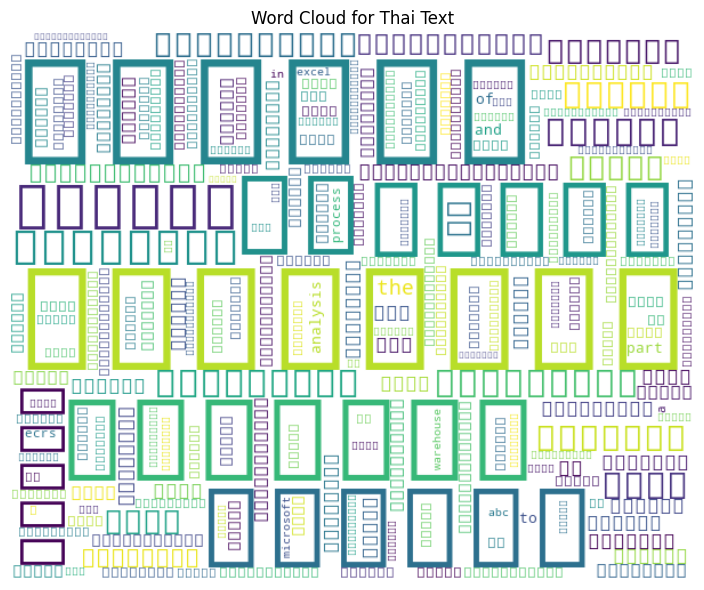

In [549]:
# Path to Thai font (change this path based on where you store the font on your machine)
thai_font_path = 'content/THSarabunNew.ttf'  # e.g. 'THSarabunNew.ttf'

# Generate WordCloud for Thai text
wordcloud = WordCloud(width=600, 
                      height=480, 
                      background_color='white').generate_from_frequencies(words_dict)
                      #font_path=font_path) \

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Thai Text')

plt.tight_layout()
plt.show()